In [293]:
#Import S&P500 Data
import yfinance as yf
import numpy as np
import pandas as pd
from pandas import DataFrame
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

#Clean data and create intended features
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Label"] = 2 * (sp500["Tomorrow"] > sp500["Close"]).astype(int) - 1

#Only uses more recent data
sp500 = sp500.loc["2020-01-01":].copy()

#Includes rolling averages for additional features
horizons = [3,10,25]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    #Ratio of closing date from yesterday over rolling average of the closing dates
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    #Sum of labels divided by number of days in rolling average
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = (sp500.shift(1).rolling(horizon).sum()["Label"])/horizon
    
    new_predictors += [ratio_column, trend_column]
    
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Label,Close_Ratio_3,Trend_3,Close_Ratio_10,Trend_10,Close_Ratio_25,Trend_25
Date,,,,,,,,,,,,,
2020-02-07 00:00:00-05:00,3335.540039,3341.419922,3322.120117,3327.709961,3733920000,3352.090088,1,0.997497,0.333333,1.012781,0.2,1.012828,0.20
2020-02-10 00:00:00-05:00,3318.280029,3352.260010,3317.770020,3352.090088,3462730000,3357.750000,1,1.003061,0.333333,1.016845,0.4,1.018794,0.28
2020-02-11 00:00:00-05:00,3365.870117,3375.629883,3352.719971,3357.750000,3762940000,3379.449951,1,1.003557,0.333333,1.016050,0.4,1.019133,0.28
2020-02-12 00:00:00-05:00,3370.500000,3381.469971,3369.719971,3379.449951,3930910000,3373.939941,-1,1.004863,1.000000,1.019345,0.6,1.023951,0.36
2020-02-13 00:00:00-05:00,3365.899902,3385.090088,3360.520020,3373.939941,3500890000,3380.159912,1,1.001056,0.333333,1.014919,0.4,1.020786,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-11 00:00:00-04:00,5172.950195,5211.779785,5138.770020,5199.060059,3509380000,5123.410156,-1,1.001771,0.333333,0.999071,0.0,1.001787,-0.04
2024-04-12 00:00:00-04:00,5171.509766,5175.029785,5107.939941,5123.410156,3963220000,5061.819824,-1,0.992709,-0.333333,0.987017,-0.2,0.987469,-0.12
2024-04-15 00:00:00-04:00,5149.669922,5168.430176,5052.470215,5061.819824,3950210000,5051.410156,-1,0.987076,-0.333333,0.978582,-0.2,0.976064,-0.12


In [294]:
#Makes the data into percentages so it can be encoded into the quantum circuit
sp500["Close"] = (sp500["Close"]-sp500["Open"])/sp500["Open"]
sp500["High"] = (sp500["High"]-sp500["Open"])/sp500["Open"]
sp500["Low"] = (sp500["Low"]-sp500["Open"])/sp500["Open"]
sp500["Volume"] = (sp500["Volume"] - sp500["Volume"].min())/sp500["Volume"].max()

#Drops data that we don't want to use in training
predictors = sp500.drop(["Open", "Tomorrow","Label"], axis=1)
predictors = DataFrame.to_numpy(predictors)
labels = (DataFrame.to_numpy(sp500))[:,6]
ninety_percent = round(predictors.shape[0]*.9)
train_predictors = predictors[0:ninety_percent,:]
test_predictors = predictors[ninety_percent+1:np.size(predictors, axis=0),:]
train_labels = labels[0:ninety_percent]
test_labels = labels[ninety_percent+1:np.size(predictors, axis=0)]
encoder_train1 = train_predictors[:,[0,1,2]]
encoder_train2 = train_predictors[:,[4,6,8]]
encoder_train3 = train_predictors[:,[5,7,9]]
num_features = np.size(predictors, axis=1)

In [295]:
import json
import time
import warnings
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

# 5 pieces of data -> 3 pieces of data
#Source: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/12_quantum_autoencoder.html

In [296]:
encoding_depth1 = 2
encoding_depth2 = 10
encoding_depth3 = 16
def ansatz(num_qubits, depth):
    return RealAmplitudes(num_qubits, reps=depth)

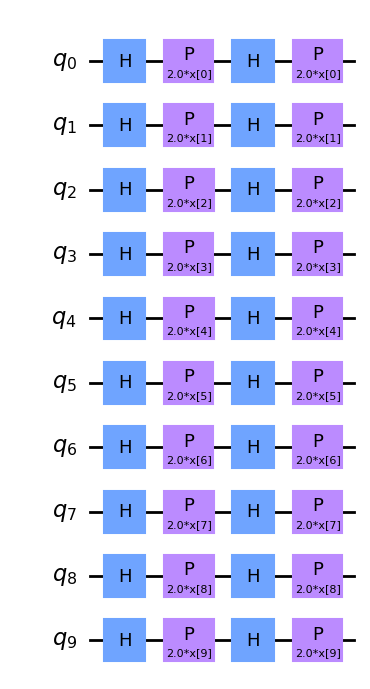

In [297]:
#Qiskits default circuit for encoding data
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit import ParameterVector
feature_map = ZFeatureMap(num_features)
feature_map.decompose().draw("mpl", style="clifford")

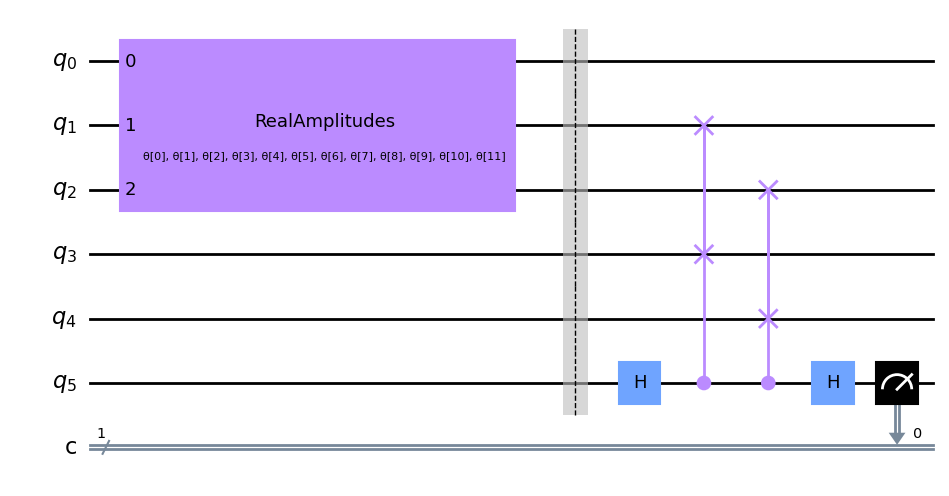

In [298]:
def auto_encoder_circuit(num_latent, num_trash, depth):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash, depth), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

num_latent = 1
num_trash = 2
circuit = auto_encoder_circuit(num_latent, num_trash, 3)
circuit.draw(output="mpl", style="clifford")

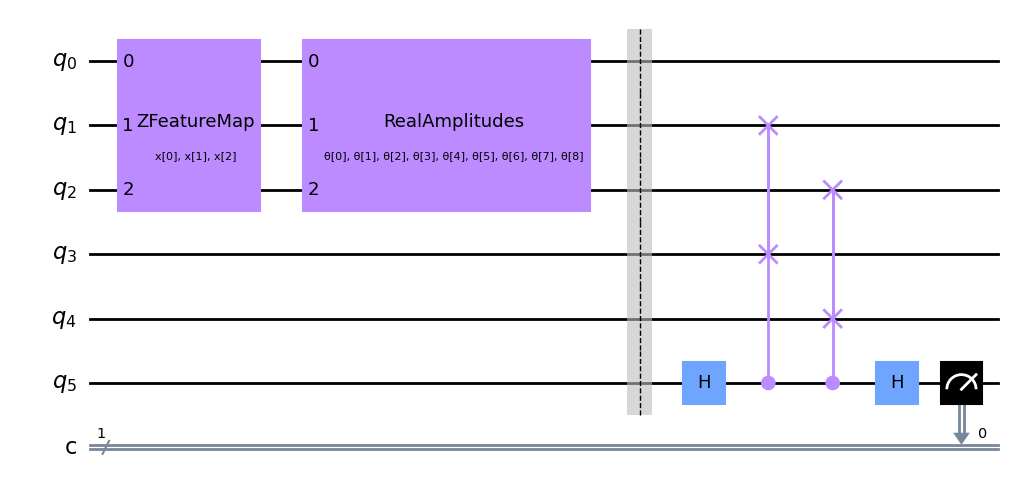

In [299]:
feature_map1 = ZFeatureMap(num_latent+num_trash)
ae1 = auto_encoder_circuit(num_latent, num_trash, encoding_depth1)
qc1 = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc1.compose(feature_map1, inplace=True)
qc1.compose(ae1, inplace=True)
qc1.draw(output="mpl", style="clifford")

In [300]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc1,
    input_params=feature_map1.parameters,
    weight_params=ae1.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [301]:
def cost_func_domain(params_values):
    probabilities = qnn.forward(encoder_train1, params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

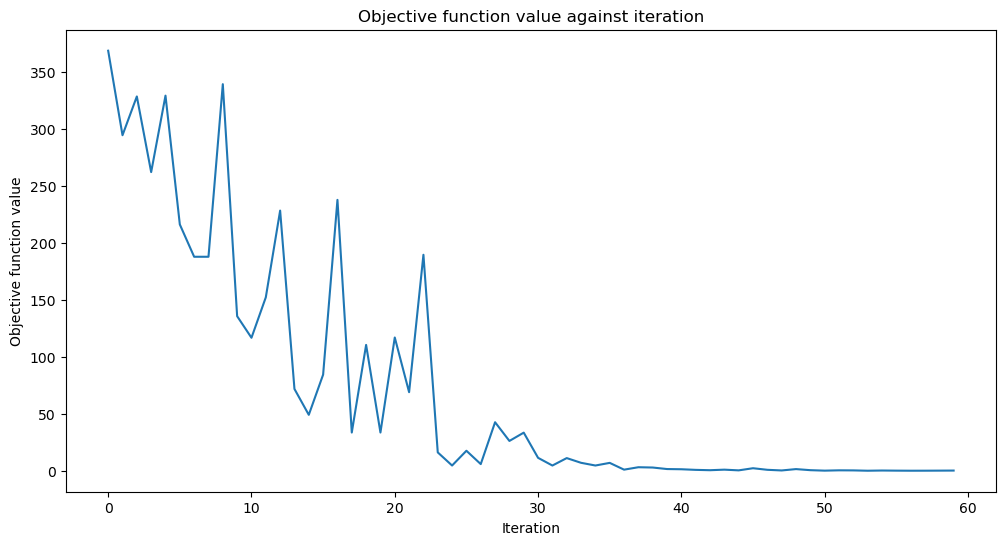

In [302]:
opt = COBYLA(maxiter=60)
initial_point = algorithm_globals.random.random(ae1.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

opt_result1 = opt.minimize(cost_func_domain, initial_point)

In [303]:
feature_map2 = ZFeatureMap(num_latent+num_trash)
ae2 = auto_encoder_circuit(num_latent, num_trash, encoding_depth2)
qc2 = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc2.compose(feature_map2, inplace=True)
qc2.compose(ae2, inplace=True)

In [304]:
qnn = SamplerQNN(
    circuit=qc2,
    input_params=feature_map2.parameters,
    weight_params=ae2.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [305]:
def cost_func_domain(params_values):
    probabilities = qnn.forward(encoder_train2, params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

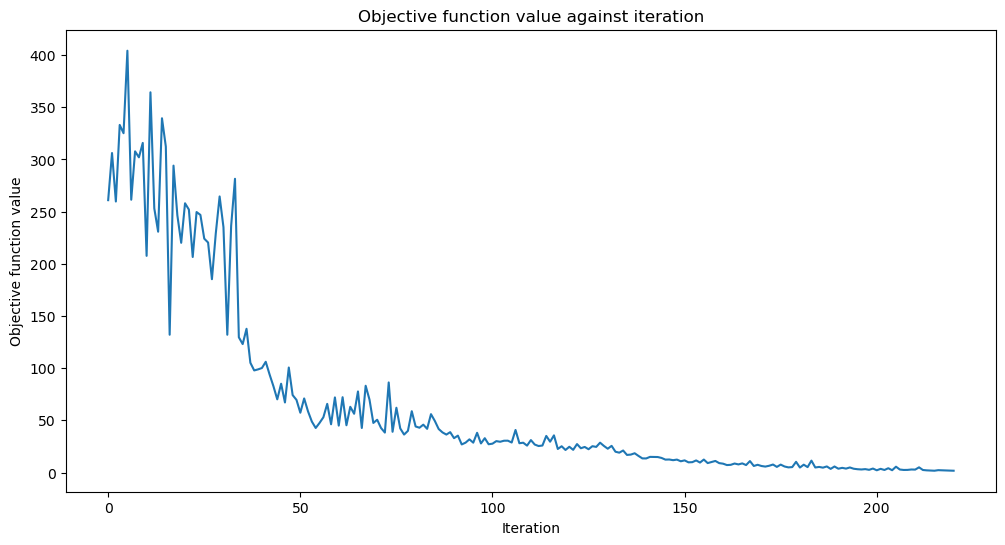

1.7747143796016942


In [306]:
opt = COBYLA(maxiter=220)
initial_point = algorithm_globals.random.random(ae2.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

opt_result2 = opt.minimize(cost_func_domain, initial_point)
print(cost_func_domain(opt_result2.x))

In [307]:
feature_map3 = ZFeatureMap(num_latent+num_trash)
ae3 = auto_encoder_circuit(num_latent, num_trash, encoding_depth3)
qc3 = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc3.compose(feature_map3, inplace=True)
qc3.compose(ae3, inplace=True)

In [308]:
qnn = SamplerQNN(
    circuit=qc3,
    input_params=feature_map3.parameters,
    weight_params=ae3.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [309]:
def cost_func_domain(params_values):
    probabilities = qnn.forward(encoder_train3, params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

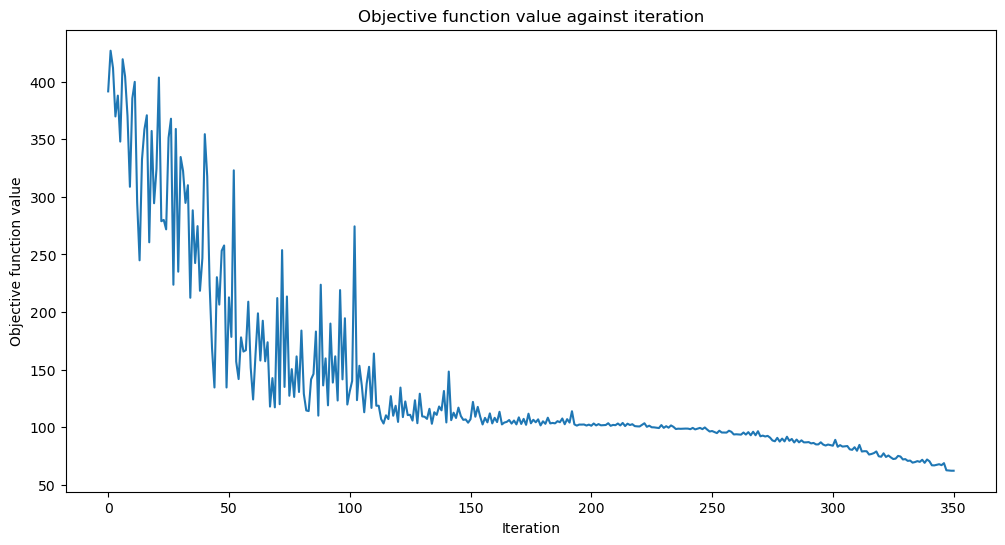

62.262890529707434


In [310]:
opt = COBYLA(maxiter=350)
initial_point = algorithm_globals.random.random(ae3.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

opt_result3 = opt.minimize(cost_func_domain, initial_point)
print(cost_func_domain(opt_result3.x))

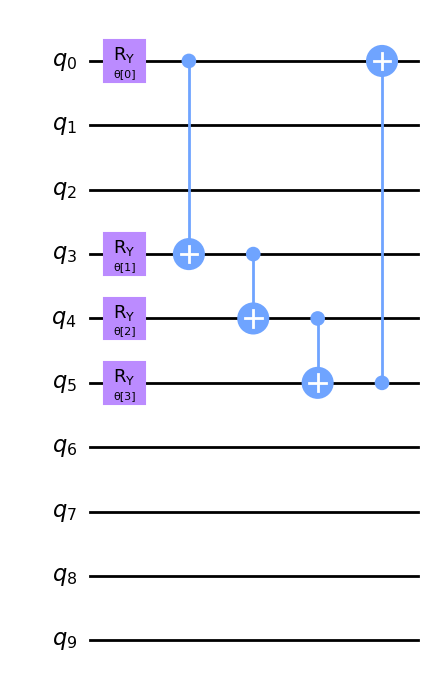

In [311]:
#Function to create the gates with parameters that we will modify through ML techniques
num_params = 4
output_qubits = [0,3,4,5]

def parametrized_gates(params):
    target = QuantumCircuit(num_features)
        
    for i in range(num_params):
        target.ry(params[i], output_qubits[i])
        
    for i in range(num_params-1):
        target.cx(output_qubits[i], output_qubits[i+1])
        
    target.cx(output_qubits[num_params-1],0)
    
    return target

#Draws the ciruit for parametrized gate
params = ParameterVector("θ", length=num_params)
circuit = parametrized_gates(params)
circuit.draw("mpl", style="clifford")

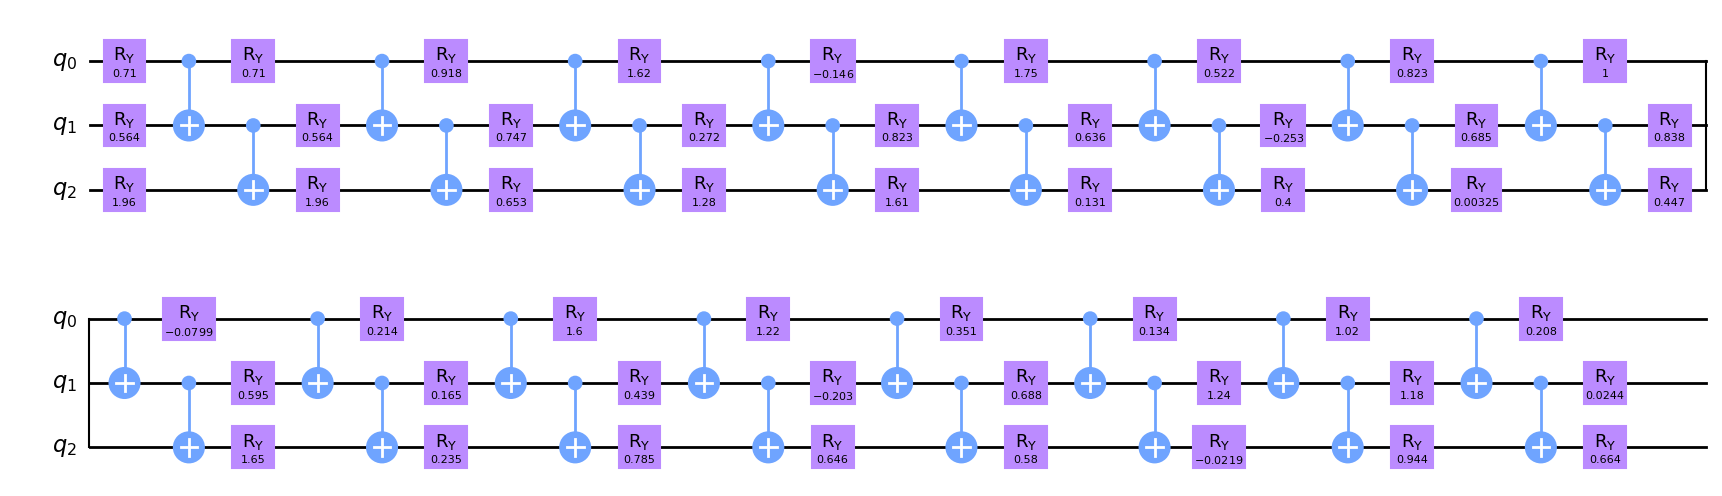

In [312]:
#Function to create the gates with parameters that we will modify through ML techniques
def trained_encoder(params, num_qubits, depth):
    target = QuantumCircuit(num_qubits)
    
    for i in range(num_qubits):
        target.ry(params[i], i)
        
    for i in range(depth):
        for j in range(num_qubits):
            if (j!=num_qubits-1):
                target.cx(j, j+1)
            target.ry(params[j + num_qubits*i], j)
    
    return target

#Draws the ciruit for parametrized gate
enc1 = trained_encoder(opt_result1.x, 3, encoding_depth1)
enc2 = trained_encoder(opt_result2.x, 3, encoding_depth2)
enc3 = trained_encoder(opt_result3.x, 3, encoding_depth3)
enc3.draw("mpl", style="clifford")

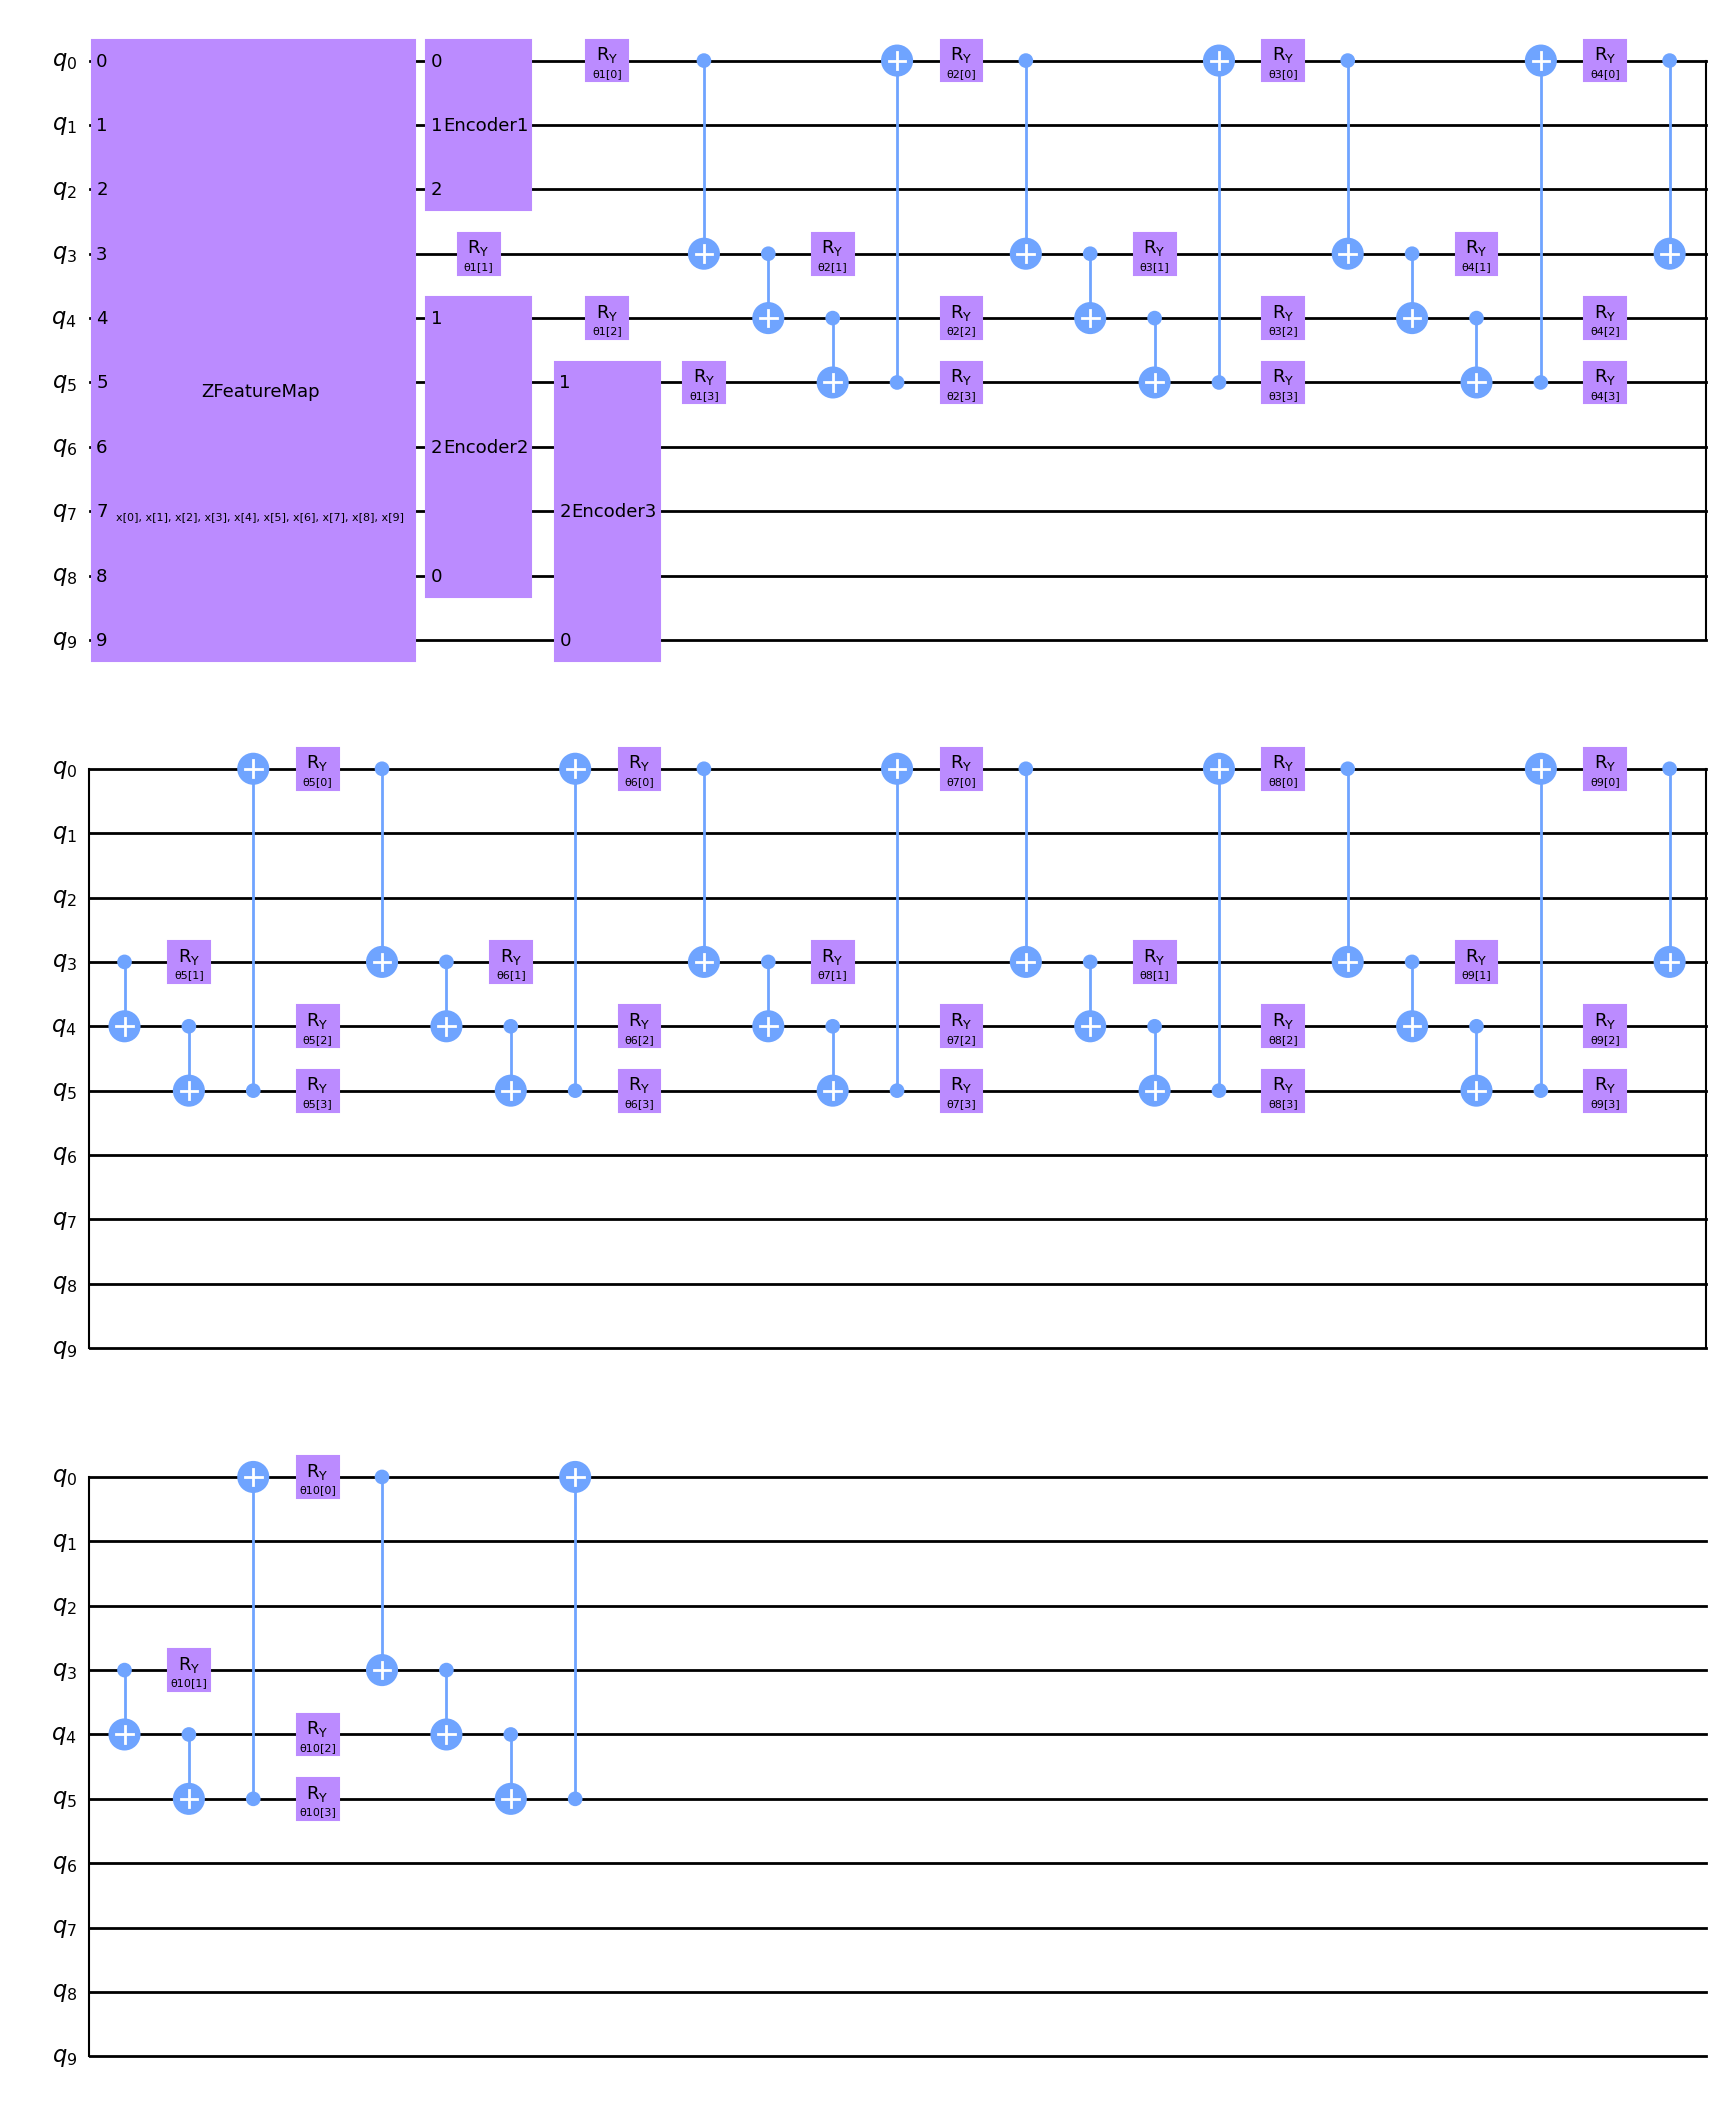

In [313]:
#Sets up full circuit with inputs and network
#network.clear()
#ml_circuit.clear()
circuit_depth = 10
network = parametrized_gates(ParameterVector("θ1", length=num_params))
for i in range(circuit_depth-1):
    network.compose(parametrized_gates(ParameterVector(f"θ{i+2}", length=num_features)), inplace=True)

ml_circuit = QuantumCircuit(num_features)
ml_circuit.compose(feature_map, inplace=True)
enc1 = enc1.to_instruction(label="Encoder1")
enc2 = enc2.to_instruction(label="Encoder2")
enc3 = enc3.to_instruction(label="Encoder3")
ml_circuit.append(enc1, {0,1,2})
ml_circuit.append(enc2, {4,6,8})
ml_circuit.append(enc3, {5,7,9})
ml_circuit.compose(network, inplace=True)
ml_circuit.draw("mpl", style="clifford")

In [314]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from IPython.display import clear_output

In [315]:
#Sets up qiskit's neural network from the library
observable = SparsePauliOp.from_list([("I" * 9 + "Z", 1)])
qnn = EstimatorQNN(
    circuit=ml_circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=network.parameters,
)

In [316]:
#Function used in classifier to plot objective function at each iteration
max_iters = 300
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [317]:
#Sets up Classifier with COBYLA optimizer
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=max_iters),
    callback=callback_graph
)

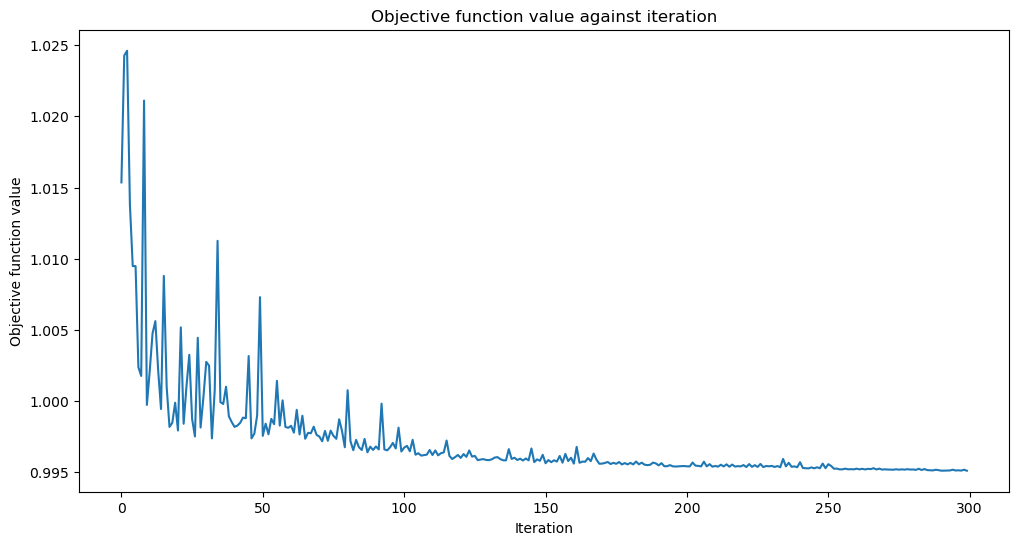

Accuracy from the training data : 51.79%


In [318]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#Trains the network and plots objective function vs iteration
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(train_predictors, train_labels)
print(f"Accuracy from the training data : {np.round(100 * classifier.score(train_predictors, train_labels), 2)}%")

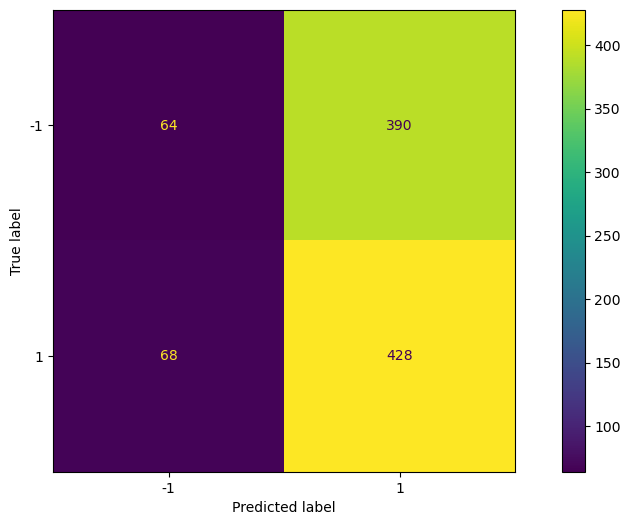

In [321]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(train_labels, classifier.predict(train_predictors))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1,1])
display.plot()
plt.show()

Accuracy from the test data : 48.08%


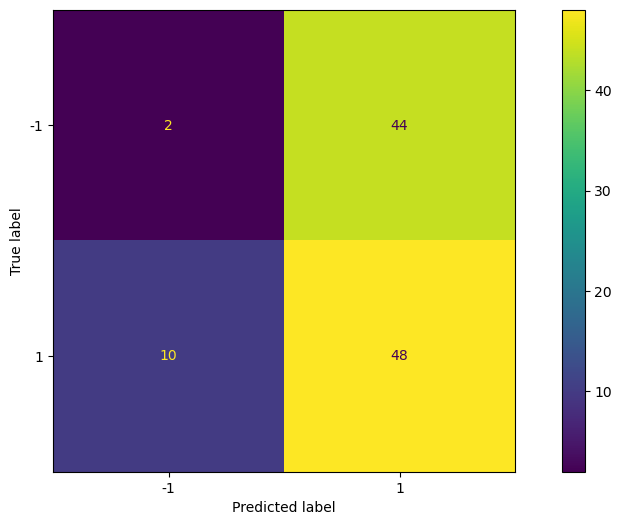

In [323]:
print(f"Accuracy from the test data : {np.round(100 * classifier.score(test_predictors, test_labels), 2)}%")
cm = confusion_matrix(test_labels, classifier.predict(test_predictors))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1,1])
display.plot()
plt.show()